Image colorization project :
We train a CNN to take in greyscale images of ... and output their colorful and plausible colorization.

Imports required :

torch

skimage ? only used for rgb - lab parsing. Maybe we can do that ourselves to make some differentiation with the original project?

numpy

matplotlib

PIL ? only used to open images to rgb. We can use another library

In [40]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
#from skimage import color
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

Load data, augment it, transform it to LAB compute stats on colors

In [41]:
#Data loading 

In [42]:
#LAB transform

In [54]:
#Color stats (auxiliary functions)

def getDiscretisedColor(a,b,gridSize):
    a = np.round(a/gridSize) * gridSize
    b = np.round(b/gridSize) * gridSize
    return (a,b)

def getMatrixIndex(a,b,gridSize):
    i = (a + 500) / gridSize
    j = (b + 200) / gridSize
    return (int(i),int(j))

def getColorValue(i,j,gridSize):
    a = i * gridSize - 500
    b = j * gridSize - 200
    return (a,b)

[array([[[79.2654367 , 22.30273916],
        [37.570884  ,  5.43822558],
        [93.59548743, 63.10022606]],

       [[70.31910002, 98.67446835],
        [ 4.6902829 , 67.73261924],
        [33.3431722 ,  5.55458338]],

       [[77.97145479, 19.7122801 ],
        [59.35973549, 16.13164548],
        [73.73307333, 52.35854979]]])]


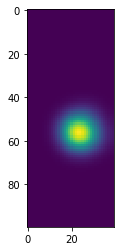

333
[(-40, 20), (-40, 30), (-40, 40), (-40, 50), (-40, 60), (-30, -10), (-30, 0), (-30, 10), (-30, 20), (-30, 30), (-30, 40), (-30, 50), (-30, 60), (-30, 70), (-30, 80), (-30, 90), (-20, -20), (-20, -10), (-20, 0), (-20, 10), (-20, 20), (-20, 30), (-20, 40), (-20, 50), (-20, 60), (-20, 70), (-20, 80), (-20, 90), (-20, 100), (-10, -30), (-10, -20), (-10, -10), (-10, 0), (-10, 10), (-10, 20), (-10, 30), (-10, 40), (-10, 50), (-10, 60), (-10, 70), (-10, 80), (-10, 90), (-10, 100), (-10, 110), (0, -40), (0, -30), (0, -20), (0, -10), (0, 0), (0, 10), (0, 20), (0, 30), (0, 40), (0, 50), (0, 60), (0, 70), (0, 80), (0, 90), (0, 100), (0, 110), (0, 120), (10, -50), (10, -40), (10, -30), (10, -20), (10, -10), (10, 0), (10, 10), (10, 20), (10, 30), (10, 40), (10, 50), (10, 60), (10, 70), (10, 80), (10, 90), (10, 100), (10, 110), (10, 120), (20, -50), (20, -40), (20, -30), (20, -20), (20, -10), (20, 0), (20, 10), (20, 20), (20, 30), (20, 40), (20, 50), (20, 60), (20, 70), (20, 80), (20, 90), (20, 

In [55]:
#Color stats

# need dataset express like that: list of images (as tensor) with dim H x W x 2 ...
images = [np.random.rand(3,3,2) * 100]
print(images)

# Initiate the proba distribution of ab pairs in the images dataset (discretised).
gridSize = 10
colorProbabilities = np.zeros((1000 // gridSize, 400 // gridSize))

# Compute the proba distribution of the ab pairs in the images dataset (discretised).
nbOfAnalysedPixels = 0
for image in images:
    for h in range (image.shape[0]):
        for w in range (image.shape[1]):
            (a,b) = getDiscretisedColor(image[h][w][0],image[h][w][1],gridSize)
            (i,j) = getMatrixIndex(a,b,gridSize)
            colorProbabilities[i][j] += 1
            nbOfAnalysedPixels += 1
colorProbabilities = colorProbabilities / nbOfAnalysedPixels

# Smooth the proba distribution of the ab pairs in the images dataset.
sigma = 5 # gaussian kernel parameter
colorProbabilities = gaussian_filter(colorProbabilities, sigma=sigma) # is it ok ? add a lot of value in gamut... take proba treshold ?

# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities, interpolation='none')
plt.show()

# Get the vector of proba of ab pairs that are "in gamut"
inGamutColors = []
inGamutColorsProbas = []
for i in range (colorProbabilities.shape[0]):
    for j in range (colorProbabilities.shape[1]):
        currentColorPorba = colorProbabilities[i][j]
        if currentColorPorba >= 0.001: # put a treshold ? if we use smoothing 
            (a,b) = getColorValue(i,j,gridSize)
            inGamutColors.append((a,b))
            inGamutColorsProbas.append(currentColorPorba)
        
Q = len(inGamutColors) 
p_smooth = torch.tensor(inGamutColorsProbas)
print(Q)
print(inGamutColors)
print(inGamutColorsProbas)
Q = 1 # to remove


In [48]:
#Define pixel weight vector (class rebalancing)

# Set the parameters (from paper, need empirical value).
lambda_uniform = 1/2 

# Compute a smooth version of the empirical pixel color distribution.
#p_smooth = p # how to do that ? gaussian kernel ? done at previous cell...

# Compute the weight vector.
pixelsWeights = torch.reciprocal((1 - lambda_uniform) * p_smooth + lambda_uniform / Q)

# Normalise the weight vector according to p_smooth (E[W] = 1).
E_W = torch.sum(p_smooth * pixelsWeights)
scale_factor = 1 / E_W
pixelsWeights = scale_factor * pixelsWeights 

Define and instantiate Convolutional NN consistent with the description of the paper. Shown in table 4.

In [45]:
#NN def

from cv2 import dilate


class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.
        
        channels_block_1 = 64
        channels_block_2 = 128
        channels_block_3 = 256
        channels_block_4 = 512
        channels_block_5 = 512 #dilated
        channels_block_6 = 512 #dilated
        channels_block_7 = 512 
        channels_block_8 = 128 # transpose convolution necessary

        nb_colour_bins = 313
        # first conv block : 2 convs. from luminosity image to 64 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock1 = nn.Sequential(nn.Conv2d(1,channels_block_1,(3,3), padding =1), 
                nn.ReLU(True), #inplace for memory efficiency can be used as no skip connections are used.
                nn.Conv2d(channels_block_1,channels_block_1,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.Relu(True),
                nn.BatchNorm2d(channels_block_1) #normalization over the 64 channels created
        )

        # second conv block. 2 covs. from 64 features to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock2 = nn.Sequential(nn.Conv2d(64,channels_block_2,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_2,channels_block_2,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_2)
        )

        # third conv block. 3 convs. from 64 to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock3 = nn.Sequential(nn.Conv2d(channels_block_2,channels_block_3,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_3)
        )

        # fourth conv block. 3 convs. from 256 to 512 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock4 = nn.Sequential(nn.Conv2d(channels_block_3,channels_block_4,(3,3), padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding =1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_4)
        )
        
        #fifth conv block. 3 convs. no change in nb feature maps. 3x3 kernels with 2 dilation and 2 padding to not downscale. normalization at the end.

        self.convBlock5 = nn.Sequential(nn.Conv2d(channels_block_4,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_5)
        )

        #sixth conv block. same as 5
        self.convBlock6 = nn.Sequential(nn.Conv2d(channels_block_5,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_6)
        )

        #seventh conv block : 3 convs with 3x3 kernels.
        self.convBlock7 = nn.Sequential(nn.Conv2d(channels_block_6,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_7)
        )

        #eighth conv block : 1 inverse conv to upsample then 2 convs with 3x3 kernels default parameters. Final convolution with 1x1 for classification into a colour bin
        self.convBlock8 = nn.Sequential(nn.ConvTranspose2d(channels_block_7,channels_block_8,(4,4),stride = 2, padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,nb_colour_bins,kernel_size=1) #1x1 kernel for classification in each colour bin (value will be soft maxed for probability)
        )

        self.outputLayer = nn.Conv2d(nb_colour_bins,2,kernel_size=1,dilation=1, bias = False) # 1x1 kernel to get 2 channel values of a and b respectively
    
    def forward(self, luminosity_image):
        h1 = self.convBlock1((luminosity_image-self.l_cent)/self.l_norm) #normalize luminosity to be on scale of 0 to 100
        h2 = self.convBlock2(h1)
        h3 = self.convBlock3(h2)
        h4 = self.convBlock4(h3)
        h5 = self.convBlock5(h4)
        h6 = self.convBlock6(h5)
        h7 = self.convBlock7(h6)
        h8 = self.convBlock8(h7)

        colour_bin_proba = (nn.Softmax(dim=1))(h8)
        output = self.outputLayer(colour_bin_proba)
        upscaled_output = (nn.Upsample(scale_factor=4, mode='bilinear'))(output) # bilinear upscale to agree with input image size 

        return upscaled_output * self.ab_norm # denormalize to cover whole ab value range
        


ModuleNotFoundError: No module named 'cv2'

Define optimizer

In [ ]:
#ADAM


Define Loss

In [ ]:
#Convert a true image Y to pixels color distributions Z (soft encoding)

# to implement...
def getColorDistribution(Y):
    return 

In [53]:
#Convert the pixel color distributions in Z[HxWxQ] to true picture estimate Y[HxWxQ] (point estimate)

# No need to be very efficient because only use when we predict (after training) ? difficult with tensor operation

def getPictureEstimate(Z,T):
    # Initiate a tensor to store the image estimated from Z.
    Y_estimate = torch.zeros(Z.shape[0], Z.shape[1], 2)
    
    # Estimate the Lab color for each pixel of the image.
    for h in range (Y_estimate.shape[0]):
        for w in range (Y_estimate.shape[1]):
            # Re-ajust the temperture of the current distribution.
            reajustedDistribution = torch.exp(torch.log10(Z[h][w]) / T)  / torch.sum(torch.exp(torch.log10(Z[h][w]) / T), 2) # check again...

            # Compute the anneled-mean of the current distribution. 
            a, b = 0, 0
            for q in range (Z.shape[2]):
                a += reajustedDistribution[q] * inGamutColors[q][0]
                b += reajustedDistribution[q] * inGamutColors[q][1]
            
            # Estimate the Lab color for the current pixel.
            Y_estimate[h][w][0] = a
            Y_estimate[h][w][1] = b
    
    # Return the estimated picture.
    return Y_estimate

In [ ]:
#v(Z_hw) weight in paper (section 2)

def getPixelsWeights(Z):
    W = torch.argmax(Z, dim=2)
    for i in range(W.size(dim=0)):
        for j in range(W.size(dim=1)):
            W[i,j] = pixelsWeights(W[i,j])

    return W


In [ ]:
#loss function 

def multinomialCrossEntropyLoss(Z_estimate, Z):
    W = getPixelsWeights(Z)
    L = - sum(W * torch.sum(Z * torch.log10(Z_estimate), dim=2))

    return L
    


Main training loop and additional function TBD